<a href="https://colab.research.google.com/github/leonardoLavagna/Drug-repurposing/blob/main/BI_LeoL_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [ ]:
!git clone https://github.com/dinaghiassian/DIAMOnD DiaBLE
!git clone https://github.com/dinaghiassian/DIAMOnD
#%pip install markov_clustering #https://github.com/GuyAllard/markov_clustering
#%pip install networkx --upgrade
#%pip install scipy --upgrade

In [ ]:
import re
import csv
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import markov_clustering as mc
from scipy.stats import hypergeom

## 1) Get the data

In [ ]:
# read the human interactome data
# https://downloads.thebiogrid.org/File/BioGRID/Release-Archive/BIOGRID-4.4.204/BIOGRID-ORGANISM-4.4.204.tab3.zip

homo_sapiens_network = pd.read_csv("/content/BIOGRID-ORGANISM-Homo_sapiens-4.4.204.tab3.txt", sep = "\t")

Filter out the same organism A and B:

In [ ]:
homo_sapiens_network = homo_sapiens_network[homo_sapiens_network['Organism Name Interactor A'] == homo_sapiens_network['Organism Name Interactor B']]

Filter out the same Gene Interactor A and B (self-loops):

In [ ]:
homo_sapiens_network = homo_sapiens_network[homo_sapiens_network['Official Symbol Interactor A'] != homo_sapiens_network['Official Symbol Interactor B']]

Filter out only the physical interactions:

In [ ]:
homo_sapiens_network = homo_sapiens_network[homo_sapiens_network['Experimental System Type'] == "physical"]

To avoid duplicating edges A-B and B-A, we'll filter them in few steps later... Now we focus on the curated disease-gene association

In [ ]:
gene_dis_association = pd.read_csv('/content/curated_gene_disease_associations.tsv', sep = '\t')
gene_dis_association = gene_dis_association[gene_dis_association['diseaseName'] == 'Hypertensive disease'] 

In [ ]:
gene_dis_association

,geneId,geneSymbol,diseaseId,diseaseName,score,NofPmids,NofSnps,source
479,10019,SH2B3,C0020538,Hypertensive disease,0.203231,0.0,0.0,HPO
850,10052,GJC1,C0020538,Hypertensive disease,0.200000,1.0,0.0,CTD_human
874,10058,ABCB6,C0020538,Hypertensive disease,0.200000,0.0,0.0,HPO
2452,10269,ZMPSTE24,C0020538,Hypertensive disease,0.200000,0.0,0.0,HPO
3619,10451,VAV3,C0020538,Hypertensive disease,0.200275,1.0,0.0,CTD_human
...,...,...,...,...,...,...,...,...
70002,4881,NPR1,C0020538,Hypertensive disease,0.219699,1.0,0.0,CTD_human
70333,490,ATP2B1,C0020538,Hypertensive disease,0.211617,1.0,2.0,CTD_human
70528,492,ATP2B3,C0020538,Hypertensive disease,0.200275,1.0,0.0,CTD_human
71092,4973,OLR1,C0020538,Hypertensive disease,0.205638,1.0,0.0,CTD_human


Effective number of disease genes present in the homo sapiens network:

In [ ]:
disease_genes_in_interactome = set.intersection(set(gene_dis_association['geneSymbol'].tolist()), set(homo_sapiens_network['Official Symbol Interactor A'].tolist()).union(homo_sapiens_network['Official Symbol Interactor B'].tolist()))

### Create human interactome

In [ ]:
human_interactome = nx.Graph()

In [ ]:
# considering the Gene IDs
human_interactome.add_nodes_from(map(int, list(set(homo_sapiens_network["Entrez Gene Interactor A"].tolist() + homo_sapiens_network["Entrez Gene Interactor B"].tolist())))) 
# human_interactome.add_nodes_from(list(set(homo_sapiens_network["Official Symbol Interactor A"].tolist() + homo_sapiens_network["Official Symbol Interactor B"].tolist())))

Now we filter the duplicates edges A-B, B-A

In [ ]:
human_interactome.add_edges_from(list(zip(map(int, homo_sapiens_network["Entrez Gene Interactor A"]), map(int, homo_sapiens_network["Entrez Gene Interactor B"]))))
# human_interactome.add_edges_from(zip(homo_sapiens_network["Official Symbol Interactor A"], homo_sapiens_network["Official Symbol Interactor B"]))

### Seed genes

In [ ]:
curated_gene_desease_association_DF = pd.read_csv("/content/curated_gene_disease_associations.tsv", sep = '\t', compression = 'infer')
     

In [ ]:
disease_DF = curated_gene_desease_association_DF.loc[curated_gene_desease_association_DF['diseaseId'] == 'C0020538']
print('Number of detected genes involved in the desease: ', len(disease_DF))
disease_DF.head(5)

Number of detected genes involved in the desease:  303


,geneId,geneSymbol,diseaseId,diseaseName,score,NofPmids,NofSnps,source
479,10019,SH2B3,C0020538,Hypertensive disease,0.203231,0,0,HPO
850,10052,GJC1,C0020538,Hypertensive disease,0.200000,1,0,CTD_human
874,10058,ABCB6,C0020538,Hypertensive disease,0.200000,0,0,HPO
2452,10269,ZMPSTE24,C0020538,Hypertensive disease,0.200000,0,0,HPO
3619,10451,VAV3,C0020538,Hypertensive disease,0.200275,1,0,CTD_human


In [ ]:
seed_list = list(disease_DF['geneId'])
print("List of Entrez genes:\n", *seed_list)

List of Entrez genes:
 10019 10052 10058 10269 10451 1071 10806 10911 10928 11020 111 11255 1161 118 1187 1215 1277 1281 1285 1286 1287 1371 1395 1401 1490 150 153 1535 1536 1543 156 1584 1585 1586 1589 1636 1813 183 1847 185 186 1889 1906 1908 1909 1956 196 2006 2056 2072 2074 210 213 2160 2161 2200 221357 2243 2263 22897 2294 22954 2301 2328 23327 2335 2353 23607 246 2475 2538 2542 26 26119 26146 26160 26249 2641 2643 2697 2701 2702 27020 27031 27130 2717 27241 2729 27347 2740 2778 2784 2796 2811 2876 2908 2920 2932 2952 2953 2982 301 3091 3145 3162 3240 3290 3291 335 3357 338 3383 3425 3479 348 348932 3553 3569 358 3630 3636 367 3717 3725 3758 3762 3779 3816 3827 389036 3949 3952 3953 3972 4000 4015 4023 4057 4069 4088 4089 4158 4190 4306 4313 4318 4363 4511 4512 4513 4514 4519 4535 4540 4541 4556 4558 4566 4567 4572 4574 4575 4577 4578 4582 4615 4627 4629 4638 475 476 4763 477 4830 4843 4846 486 4867 4878 4879 4881 490 492 4973 4982 5020 50485 5054 5076 50940 51057 51083 5139 5167 

In [ ]:
print("List of gene symbols:\n", *list(disease_DF['geneSymbol']))
seed_genes_symbols = list(disease_DF['geneSymbol'])

List of gene symbols:
 SH2B3 GJC1 ABCB6 ZMPSTE24 VAV3 CETP SDCCAG8 UTS2 RALBP1 IFT27 ADCY5 HRH3 ERCC8 ADD1 CLCNKA CMA1 COL1A1 COL3A1 COL4A3 COL4A4 COL4A5 CPOX CRHR2 CRP CTGF ADRA2A ADRB1 CYBA CYBB CYP1A1 GRK2 CYP11B1 CYP11B2 CYP17A1 CYP21A2 ACE DRD2 AGT DUSP5 AGTR1 AGTR2 ECE1 EDN1 EDN3 EDNRA EGFR AHR ELN EPO ERCC4 ERCC6 ALAD ALB F11 F12 FBN1 GSTA5 FGA FGFR2 CEP164 FOXF1 TRIM32 FOXE3 FMO3 NEDD4L FN1 FOS CD2AP ALOX15 MTOR G6PC SLC37A4 AOC1 LDLRAP1 TRAF3IP1 IFT172 KLHL3 GCG GCH1 GJA1 GJA4 GJA5 NPTN NPHP3 INVS GLA BBS9 GCLC STK39 GLP1R GNAS GNB3 GNRH1 GP1BA GPX1 NR3C1 CXCL2 GSK3B GSTT1 GSTT2 GUCY1A3 ANXA1 HIF1A HMBS HMOX1 HP HSD11B1 HSD11B2 APOA1 HTR2B APOB ICAM1 IDUA IGF1 APOE SLC6A18 IL1B IL6 AQP1 INS INPPL1 AR JAK2 JUN KCNJ1 KCNJ5 KCNMB1 KLK1 KNG1 ACT LDLR LEP LEPR LHB LMNA LOX LPL LTF LYZ SMAD3 SMAD4 MC2R MDH1 NR3C2 MMP2 MMP9 ABCC1 TRNC COX1 COX2 COX3 CYTB ND1 ND5 ND6 TRNE TRNF TRNK TRNL1 TRNQ TRNS1 TRNS2 TRNV TRNW MUC1 MYD88 MYH9 MYH11 MYLK ATOX1 ATP1A1 NF1 ATP1A2 NME1 NOS2 NOS3 FXYD2

In [ ]:
disease_DF['geneSymbol'].to_csv('gene_symbols.csv', index = False, header = False, line_terminator = ',')

In [ ]:
disease_DF['geneId'].to_csv('geneId.csv', index = False, header = False, line_terminator = ',')

In [ ]:
disease_DF

,geneId,geneSymbol,diseaseId,diseaseName,score,NofPmids,NofSnps,source
479,10019,SH2B3,C0020538,Hypertensive disease,0.203231,0,0,HPO
850,10052,GJC1,C0020538,Hypertensive disease,0.200000,1,0,CTD_human
874,10058,ABCB6,C0020538,Hypertensive disease,0.200000,0,0,HPO
2452,10269,ZMPSTE24,C0020538,Hypertensive disease,0.200000,0,0,HPO
3619,10451,VAV3,C0020538,Hypertensive disease,0.200275,1,0,CTD_human
...,...,...,...,...,...,...,...,...
126779,9445,ITM2B,C0020538,Hypertensive disease,0.200000,1,0,CTD_human
127097,948,CD36,C0020538,Hypertensive disease,0.209195,1,0,CTD_human
128361,9657,IQCB1,C0020538,Hypertensive disease,0.200000,0,0,HPO
130166,9935,MAFB,C0020538,Hypertensive disease,0.200000,0,0,HPO


### LLC

In [ ]:
LCCs = [len(human_interactome) for human_interactome in sorted(nx.connected_components(human_interactome), key=len, reverse=True)]
print(f"The largest component {LCCs[0]}") 

The largest component 3289


In [ ]:
print(LCCs)

[3289, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [ ]:
# extract first LLC
human_interactome_LCC = human_interactome.subgraph(max(nx.connected_components(human_interactome), key=len))
print(len(human_interactome_LCC)) # number of nodes in the largest component
print(len(human_interactome_LCC.edges()))

3289
6390


In [ ]:
# save graph
nx.write_adjlist(human_interactome_LCC, "test.adjlist")

In [ ]:
# plot subgraph LLC (takes a while...)

#spring_pos = nx.spring_layout(human_interactome_LCC)
#nx.draw_networkx(human_interactome_LCC,pos=spring_pos,with_labels=False,node_size=5)

### LCC and local measures

In [ ]:
G = human_interactome_LCC.copy()

In [ ]:
# Local measures (this cell takes a while to run...)

nx.set_node_attributes(G, G.degree(), 'Node degree')  
nx.set_node_attributes(G, nx.betweenness_centrality(G), "Betweenness centrality")
nx.set_node_attributes(G, nx.eigenvector_centrality(G), "Eigenvector centrality")
nx.set_node_attributes(G, nx.closeness_centrality(G), "Closeness centrality")

local_measures = pd.DataFrame(index=G.nodes())
local_measures['Node degree'] = [d for n, d in G.degree()] 
local_measures['Betweenness centrality'] = pd.Series(nx.get_node_attributes(G, 'Betweenness centrality'))
local_measures['Eigenvector centrality'] = pd.Series(nx.get_node_attributes(G, 'Eigenvector centrality'))
local_measures['Closeness centrality'] = pd.Series(nx.get_node_attributes(G, 'Closeness centrality'))
local_measures['Betweenness/Degree Ratio'] = local_measures['Betweenness centrality']/local_measures['Node degree']
local_measures.index.name='Gene'


In [ ]:
# Table 

local_measures.to_csv('local_measures.csv', index = True, header = True)

local_measures = pd.read_csv('/content/local_measures.csv', sep=',')
local_measures.head(50)


,Unnamed: 0,Gene,Node degree,Betweenness centrality,Eigenvector centrality,Closeness centrality,Betweenness/Degree Ratio
0,0,8195,3,0.000013,7.178462e-04,0.196018,0.000004
1,1,90121,1,0.000000,2.246281e-05,0.166650,0.000000
2,2,8202,3,0.000138,3.079436e-03,0.224944,0.000046
3,3,8204,10,0.004332,5.398281e-02,0.244534,0.000433
4,4,81932,1,0.000000,2.818070e-03,0.196604,0.000000
5,5,8208,1,0.000000,1.247827e-04,0.184709,0.000000
6,6,19,1,0.000000,2.334283e-04,0.170628,0.000000
7,7,8215,1,0.000000,1.124251e-06,0.135784,0.000000
8,8,25,15,0.007199,6.350334e-03,0.238780,0.000480
9,9,27,1,0.000000,4.056665e-04,0.192765,0.000000


### Optional Task 3 MCL

In [ ]:
result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))           
clusters = mc.get_clusters(result) 

<ipython-input-24-15c467d2635c>:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  result = mc.run_mcl(nx.to_scipy_sparse_matrix(G))


<ipython-input-25-a28981f70505>:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  mc.draw_graph(nx.to_scipy_sparse_matrix(G), clusters, node_size=10, with_labels=False, edge_color="silver")


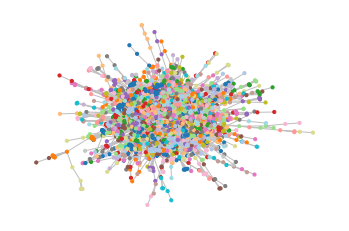

In [ ]:
mc.draw_graph(nx.to_scipy_sparse_matrix(G), clusters, node_size=10, with_labels=False, edge_color="silver")

In [ ]:
# perform clustering using different inflation values from 1.5 and 2.5
# for each clustering run, calculate the modularity
matrix = nx.to_scipy_sparse_matrix(G)
for inflation in [i / 10 for i in range(15, 26)]:
    result = mc.run_mcl(matrix, inflation=inflation)
    clusters = mc.get_clusters(result)
    Q = mc.modularity(matrix=result, clusters=clusters)
    print("inflation:", inflation, "modularity:", Q)

<ipython-input-26-a52a70740a59>:3: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  matrix = nx.to_scipy_sparse_matrix(G)


inflation: 1.5 modularity: 0.8848068661597701
inflation: 1.6 modularity: 0.8602897238569474
inflation: 1.7 modularity: 0.8307147938396688
inflation: 1.8 modularity: 0.8002666272484542
inflation: 1.9 modularity: 0.7798313023715556
inflation: 2.0 modularity: 0.7656593409894846
inflation: 2.1 modularity: 0.7564628716690194
inflation: 2.2 modularity: 0.7465789990146472
inflation: 2.3 modularity: 0.7339676068111993
inflation: 2.4 modularity: 0.7228727358144171
inflation: 2.5 modularity: 0.7138325869670057


Now that we have found the clusters, we filter them in order to keep only those having at least 10 nodes and in which the seed genes are statistically overrepresented. The resulting sets are the putative desease modules.

In [ ]:
# keep clusters with at least 10 genes
big_clusters = []
for module in clusters:
    if len(module) >= 10:
        big_clusters.append(module)
print(len(clusters), len(big_clusters))

934 43


In [ ]:
# dictionary with mapping between {nodeID : gene name}
val = range(G.number_of_nodes())
names = list(G.nodes())
dic = dict(zip(val, names))

In [ ]:
# run the hypergeometric test to find modules with statistically overrepresented seed genes
putative_desease_modules = []
M = G.number_of_nodes() # population size (total number of genes) 
n = len(seed_genes_symbols) # number of seed genes
p_val_list = []
for module in big_clusters:
    N = len(module) # number of draws (number of genes in the given cluster)
    x = len(set(seed_genes_symbols).intersection(set(dic[g] for g in module)))
    p_val = hypergeom.sf(x-1, M, n, N)
    if p_val < 0.05:
        putative_desease_modules.append(module)
        p_val_list.append(p_val)

In [ ]:
for i in range(len(putative_desease_modules)):
    print("Desease putative module ",i, ": ", *[dic[g] for g in putative_desease_modules[i]])

In [ ]:
header = ['ModuleID', "Number of seed genes/module", "Module size", "Seed genes", "All genes", "p-value"]
df_putative_desease_modules = pd.DataFrame(columns=header)
for i in range(len(putative_desease_modules)):
    seeds = set(seed_genes_symbols).intersection(set(dic[g] for g in putative_desease_modules[i]))
    values = [i, len(seeds), len(putative_desease_modules[i]), seeds, [dic[g] for g in putative_desease_modules[i]],p_val_list[i]]
    df = pd.DataFrame( [values], columns = header)
    df_putative_desease_modules = df_putative_desease_modules.append(df, ignore_index=True)

In [ ]:
# ???
df_putative_desease_modules

,ModuleID,Number of seed genes/module,Module size,Seed genes,All genes,p-value
